<a href="https://colab.research.google.com/github/salaheddinos/housepredictionapp/blob/master/WEBSCRAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WEBSCRAPER CODE

In [2]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from time import sleep
# Paid Proxy Service
# from scrapingbee import ScrapingBeeClient

In [ ]:
# Test proxy
api_key = "YOURAPIKEY"
client = ScrapingBeeClient(api_key=api_key)
response = client.get('https://httpbin.org/ip')

print('Response HTTP Status Code: ', response.status_code)
print('Response HTTP Response Body: ', response.content)

Response HTTP Status Code:  200
Response HTTP Response Body:  b'{\n  "origin": "23.254.1.140"\n}\n'


In [ ]:
# Get Ad num func
def get_adNum(soup):
  ad_num = re.search(r'Ad:([0-9]+)', soup.find('script', type='application/json').text).group()
  return ad_num

In [ ]:
# Get equipments func
def get_equip(data, adnum):
  equip = data["props"]["pageProps"]["apolloState"][adnum]["params"]["extra"]
  equip_dic = {}
  for i in range(len(equip)):
    equip_dic[equip[i]["label"]] = data["props"]["pageProps"]["apolloState"][adnum]["params"]["extra"][i]["value"]
  
  return equip_dic

In [ ]:
# Get listing details func
def get_details(data, adnum):
  details = data["props"]["pageProps"]["apolloState"][adnum]["params"]["primary"]
  details_dic = {}
  for i in range(len(details)):
    details_dic[details[i]["label"]] = details[i]["value"]

  return details_dic

In [ ]:
# Get more_details func
def get_moreDetails(data, adnum):
  more_details = pd.DataFrame(data["props"]["pageProps"]["apolloState"][adnum]["params"]["secondary"]).iloc[:,2:].set_index("label").T
  more_details_dic = {}
  for col in more_details.columns:
    more_details_dic[col] = str(more_details[col].values).replace("[","").replace("]","").replace("'","")

  return more_details_dic

In [ ]:
# Get price and description func
def get_Price_Desc(data, adnum):
  price_desc_dic = {"Description":data["props"]["pageProps"]["apolloState"][adnum]["description"].replace('\n', ""),
                           "Prix":data["props"]["pageProps"]["apolloState"][adnum]["price"]["value"]} 
  return price_desc_dic

In [ ]:
# Get urls function
def getURLS(startpage, numpages, city, type):
  urls = []
  for i in range(startpage,(startpage+numpages)):
    url = f"https://www.WEBSITENAME.ma/fr/{city}/{type}?o={i}&price_min=200000"
    try:
      reqs = client.get(url)
      soup = BeautifulSoup(reqs.text, 'html.parser')
      for link in soup.find_all("a", attrs={"class": 'oan6tk-1 fFOxTQ'}):
        data = link.get('href')
        urls.append(data)
    except:
      print(f"Page {i} Failed")
      pass

  print("N° of URLS fetched:",len(urls))    
  return urls

In [ ]:
# Get multiple listings and return df func
def get_multiple(urls, cityName):
  print(f"Scraping {len(urls)} URLS in estimated time of {round((len(urls)*8.57)/60)} min...")
  results = []
  adnum = []
  count = 0
  requests_failed = 0
  failed_urls = []

  for url in urls:
    try:
      # random_id = randint(0,10000000)
      count += 1
      page = client.get(url)
    #   ,
    #   params = { 
    #     'timeout': '50000',
    #     'session_id' : random_id
    # }
      if page.status_code != 200:
        requests_failed += 1
      soup = BeautifulSoup(page.content, 'html.parser')
      adnum.append(get_adNum(soup))
      data = json.loads(soup.find('script', type='application/json').text)
      results.append(data) 
      print(f"URL N° {count} Scraped")
    except:
      failed_urls.append(url)
      print(f"URL N° {count} Failed!")
      pass

  # return results, adnum
  
  # DataFrame creation
  print("Populating DataFrame...")
  equip_df = pd.DataFrame()
  details_df = pd.DataFrame()
  more_details_df = pd.DataFrame()
  phone_df = pd.DataFrame()
  price_desc_df = pd.DataFrame()
  ville_df = pd.DataFrame()
  full_df = None
  
  for i in range(len(results)):
    try:
      equip_dic = get_equip(results[i], adnum[i])
      equip_df = equip_df.append(equip_dic, ignore_index=True)
      details_dic = get_details(results[i], adnum[i])
      details_df = details_df.append(details_dic, ignore_index=True)
      more_details_dic = get_moreDetails(results[i], adnum[i])
      more_details_df = more_details_df.append(more_details_dic, ignore_index=True)
      price_desc_dic = get_Price_Desc(results[i], adnum[i])
      price_desc_df = price_desc_df.append(price_desc_dic, ignore_index=True)
      ville_df = ville_df.append({"Ville": cityName}, ignore_index=True)
      full_df = pd.concat([equip_df, details_df, more_details_df, phone_df, price_desc_df, ville_df], axis=1)
    except:
      pass
  
  # Get final df
  try:
    df_1 = pd.read_csv("WEBSITEDATA.csv", sep='\t')
  except:
    df_1 = pd.read_csv("WEBSITEDATA.csv")  
  df_c = pd.concat([df_1.loc[:,~df_1.columns.duplicated()], full_df.loc[:,~full_df.columns.duplicated()]]).reset_index(drop=True)
  df_c = df_c.loc[:,"Garage":]
  df_c.to_csv("WEBSITEDATA.csv", sep='\t')

  print("DataFrame successfully created!")
  print("Requests Success Rate:", (100*(1 - round(requests_failed/len(urls), 2))),"%")
  print("URLS not Scraped:", len(failed_urls))
  # Set alarm when code finishes running
  duration = 1000  # milliseconds
  freq = 440  # Hz
  winsound.Beep(freq, duration)

  return df_c, failed_urls

In [ ]:
# Get urls 
# Types : maisons_et_villas-à_vendre & appartements-à_vendre
# ENTER CITY NAME + TYPE OF LISTING
cityName = "casablanca"
urls = getURLS(1, 5, cityName, "maisons_et_villas-à_vendre")

N° of URLS fetched: 105


In [ ]:
# Save HTML links to file
# opening a file in write mode
f = open("urls.txt", "w", encoding='utf-8')
for url in urls:
  f.write(url)
  f.write("\n")
f.close()

In [ ]:
# Get data and populate df
df_c, failed_urls = get_multiple(urls[:5], cityName.capitalize())

In [ ]:
# Get urls from file
with open('urls.txt', 'r', encoding='utf-8') as f:
    urls = [line.strip() for line in f]

In [ ]:
# Get failed requests
df_c, failed_urls = get_multiple(failed_urls, "Rabat")

MACHINE LEARNING MODEL

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [16]:
# Some more cleaning
fulldata = pd.read_csv("/content/DATA.csv")
fulldata = fulldata.drop("Unnamed: 0", axis=1)

In [17]:
fulldata.head()

,Ville,Secteur,Type,Surface habitable m²,Surface totale m²,Âge du bien,Salons,Chambres,Salle de bain,Garage,Jardin,Piscine,Balcon,Prix / m²,Prix
0,Agadir,Abattoirs,Maisons et villas,52,52,21+ ans,2,5,3,Non,Non,Non,Non,11538.46,600000.0
1,Agadir,Abattoirs,Maisons et villas,61,61,21+ ans,1,5,2,Non,Non,Non,Non,11147.54,680000.0
2,Agadir,Abattoirs,Maisons et villas,53,64,Neuf,3,6,3,Non,Non,Non,Non,34375.00,2200000.0
3,Agadir,Abattoirs,Maisons et villas,198,66,11-20 ans,1,6,4,Non,Non,Non,Non,15151.52,1000000.0
4,Agadir,Abattoirs,Appartements,130,130,Neuf,2,3,2,Non,Non,Non,Oui,4000.00,520000.0


In [6]:
# Replace nans for Nombre d'étage and Salons with mode
def replacenans(df):
  df.Salons = df.Salons.fillna(df["Salons"].mode()[0])  
  df["Nombre d'étage"] = df["Nombre d'étage"].fillna(df["Nombre d'étage"].mode()[0])
  df["Étage"] = df["Étage"].fillna(df["Étage"].mode()[0])
  # df["Âge du bien"] = df["Âge du bien"].fillna(df["Âge du bien"].mode()[0])
  return df

In [ ]:
fulldata = replacenans(fulldata)

In [18]:
fulldata.shape

(4064, 15)

In [ ]:
# Get Dataframe with frequency of sectors of at least 10
fulldata10 = fulldata[fulldata.groupby(["Ville","Secteur"])["Secteur"].transform('size') > 10 ]

In [ ]:
fulldata10.shape

(6515, 27)

In [ ]:
# Split data
aptdf = fulldata10[fulldata10.Type == "Appartements"]
homedf = fulldata10[fulldata10.Type == "Maisons et villas"]
print("Shape of aptdf:",aptdf.shape)
print("Shape of homedf:", homedf.shape)

Shape of aptdf: (2921, 27)
Shape of homedf: (3594, 27)


In [ ]:
# Exclude some features
excludeFromAPT = ["Garage", "Jardin", "Piscine", "Duplex", "Nombre d'étage"]
excludeFromHomes = ["Ascenseur", "Concierge", "Duplex", "Étage"]
excludeFromfullData = ["Sécurité", "Ascenseur", "Concierge", "Duplex", "Nombre d'étage"]

In [ ]:
aptdf.drop(excludeFromAPT, axis=1, inplace=True)
homedf.drop(excludeFromHomes, axis=1, inplace=True)
fulldata10.drop(excludeFromfullData, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove outliers
fulldata10 = fulldata10[fulldata10.Prix <= fulldata10.Prix.quantile(.99)]
fulldata10.shape

(6452, 22)

In [ ]:
fulldata10.describe()

,Surface habitable m²,Surface totale m²,Prix / m²,Prix
count,6452.000000,6452.000000,6452.000000,6.452000e+03
mean,167.102759,178.545257,11667.873605,1.879275e+06
std,186.524134,215.869160,10984.475406,2.149796e+06
min,42.000000,49.000000,390.120000,2.000000e+05
25%,73.000000,74.000000,6205.175000,5.600000e+05
50%,100.000000,101.000000,9027.780000,1.020000e+06
75%,168.000000,172.000000,13671.055000,2.300000e+06
max,2040.000000,2070.000000,245454.550000,1.400000e+07


In [ ]:
# Remove outliers for Surface Habitable et totale of >= 1500
fulldata10 = fulldata10[(fulldata10["Surface habitable m²"] < 1500) & 
                        (fulldata10["Surface totale m²"] < 1500)]

In [ ]:
# Remove outliers for Surfaces < 200 and Prix > 800K
remove = fulldata10[(fulldata10["Surface habitable m²"] < 200) & 
                        (fulldata10.Prix > 8000000)].index

fulldata10.drop(remove, axis=0, inplace=True)

In [ ]:
fulldata10["Secteur"] = fulldata10["Secteur"].apply(lambda x: "Autre secteur" if x == "Toute la ville" else x)

In [ ]:
#Drop nans
fulldata10.dropna(inplace=True)

In [ ]:
# Save to excel
# fulldata20xl = fulldata10.to_excel("fulldata20.xlsx")
fulldata20csv = fulldata10.to_csv("fulldata20csv.csv")

************************************************************


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


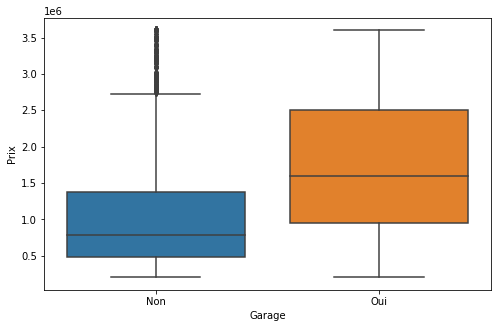

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


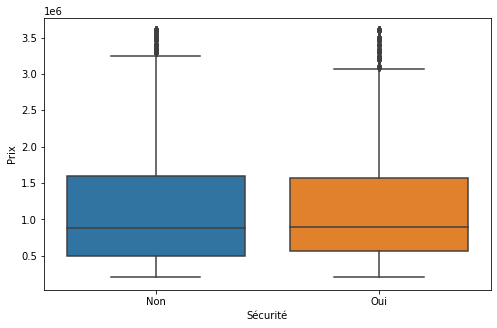

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


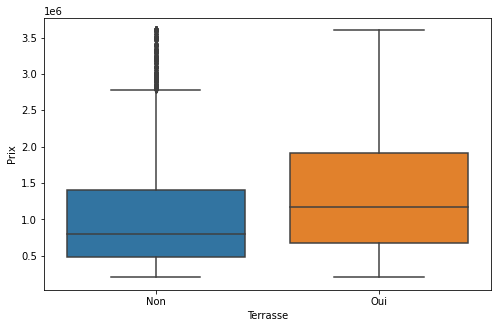

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


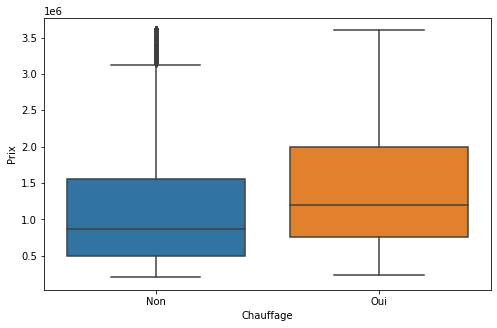

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


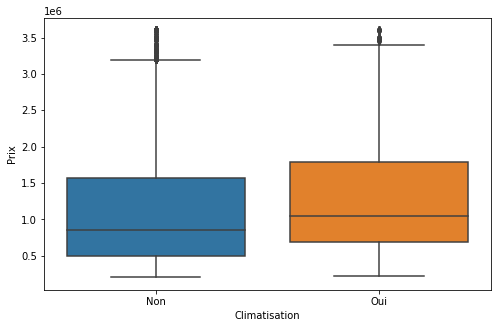

************************************************************


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


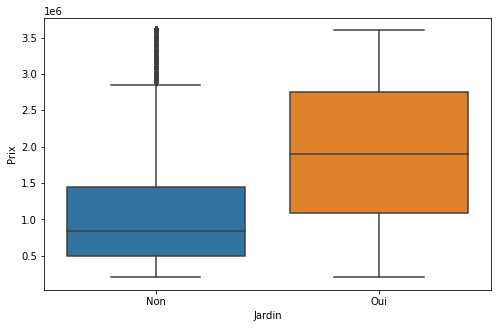

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


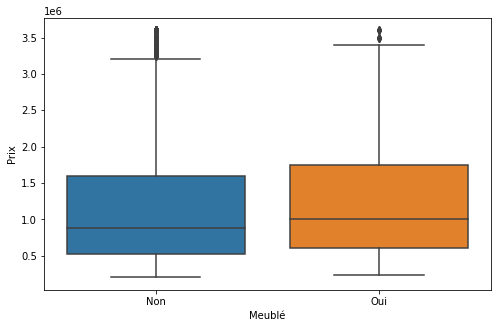

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


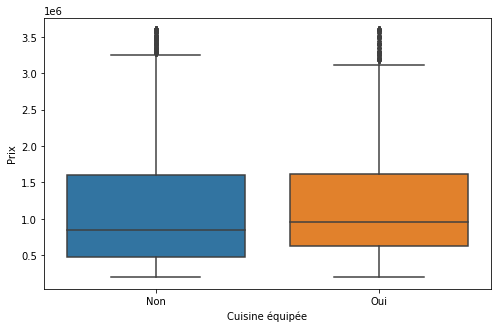

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


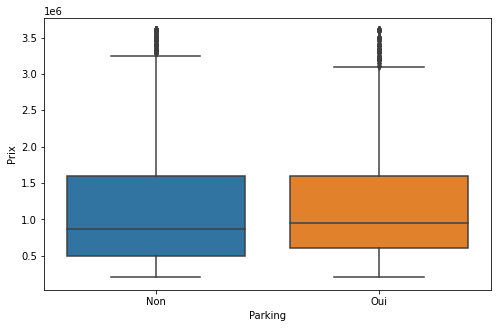

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


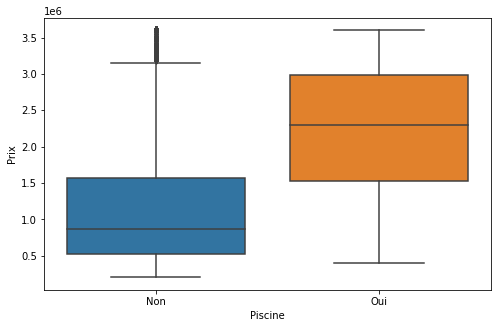

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


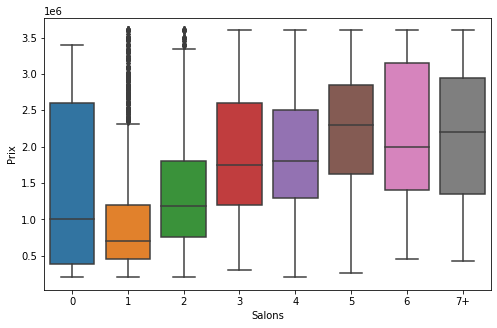

************************************************************


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


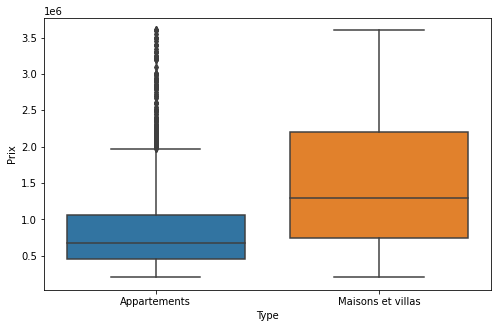

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


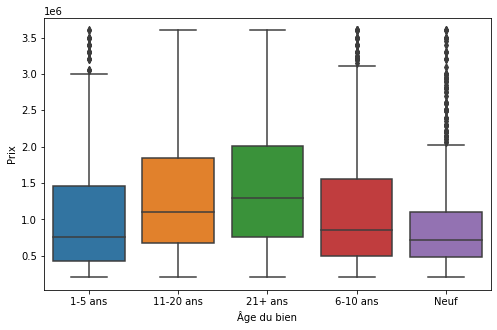

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


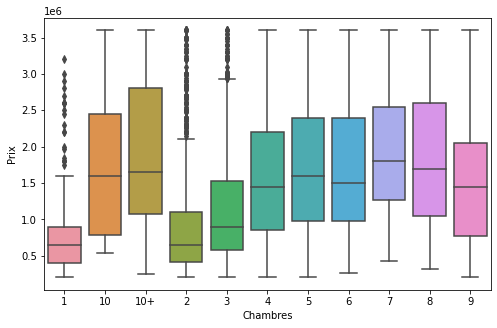

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


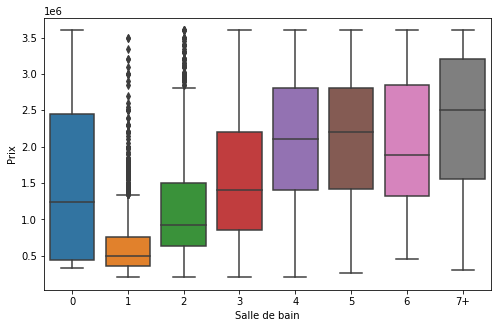

************************************************************


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


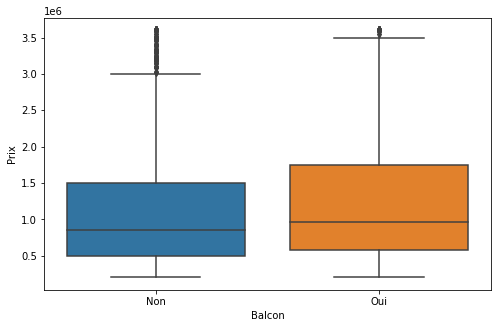

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


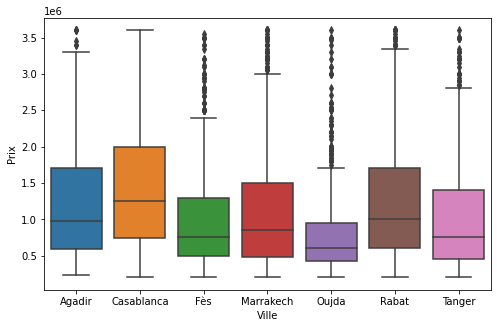

************************************************************


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


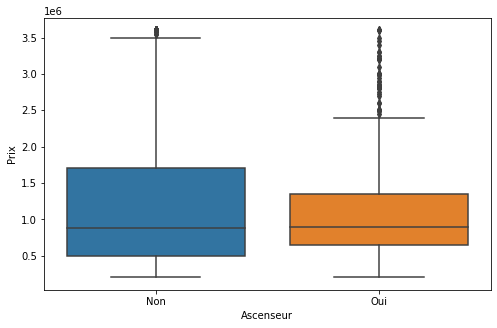

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


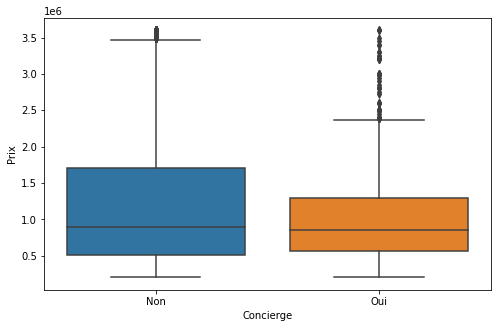

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


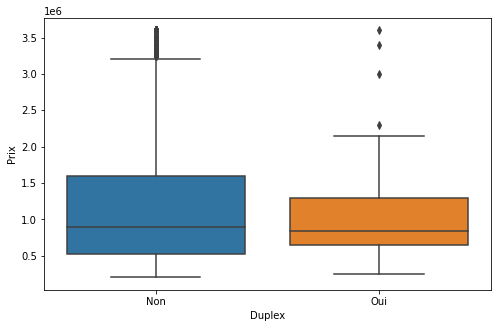

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


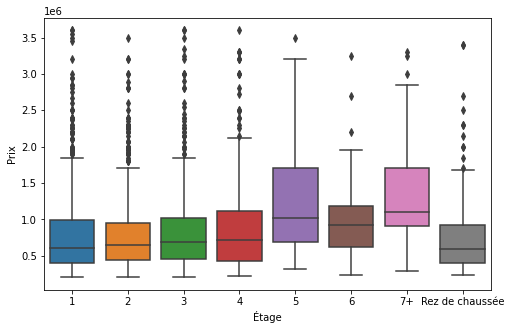

In [ ]:
# Qualtitative features VS Price
for col in fulldata.columns:
  if fulldata[col].dtype == "object" and col != "Secteur":
    plt.figure(figsize=(8,5))
    sns.boxplot(fulldata[col].sort_values(), fulldata.Prix)
    print("**"*30)
    plt.show()

# Sécurité, Concièrge, Duplex

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


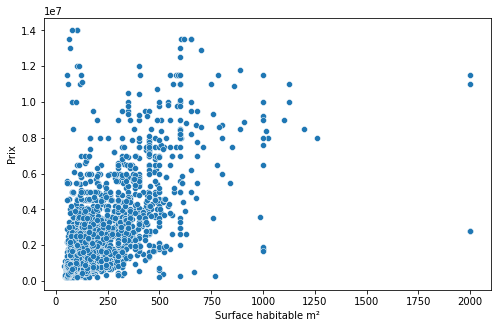

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


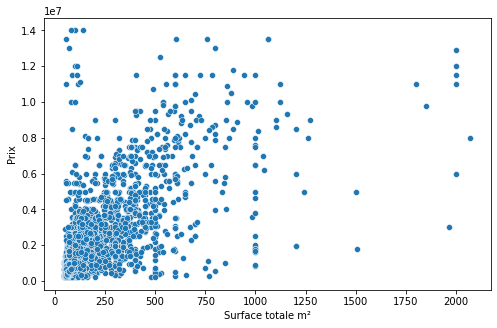

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


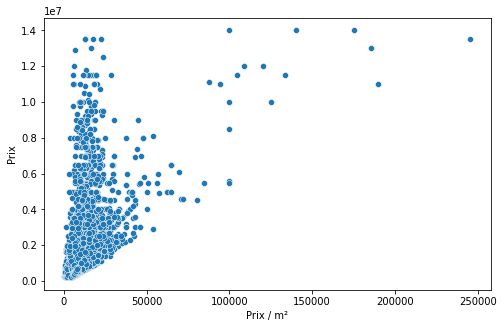

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


************************************************************


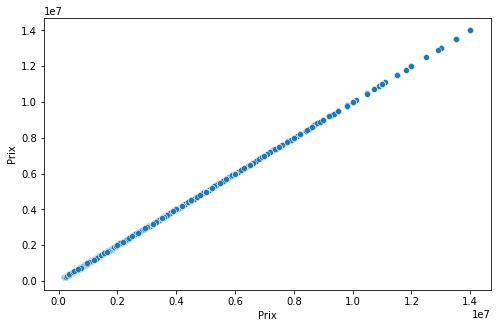

In [ ]:
# Quantitative features VS Price
for col in fulldata10.columns:
  if fulldata10[col].dtype != "object":
    plt.figure(figsize=(8,5))
    sns.scatterplot(fulldata10[col], fulldata10.Prix)
    print("**"*30)
    plt.show()

In [ ]:
fulldata10.shape

(6391, 22)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


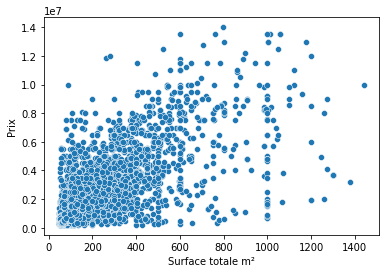

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


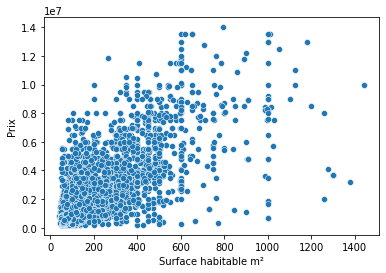

In [ ]:
sns.scatterplot(fulldata10["Surface totale m²"], fulldata10.Prix)
plt.show()
sns.scatterplot(fulldata10["Surface habitable m²"], fulldata10.Prix)
plt.show()

In [43]:
def trainandtest(df, model):
  # Drop na
  print("Before nan's drop:", df.shape)
  df.dropna(inplace=True)
  print("After nan's drop:", df.shape)  
  # Set X and y
  X = df.drop(["Prix", "Prix / m²"], axis=1)
  y = df.Prix
  # Set features to encode
  features_to_encode = X.columns[X.dtypes==object].tolist()
  # Encode train set
  X = pd.get_dummies(X, columns = features_to_encode)
  # Init model
  # (10, 50, 100, 1000)
  model_ = model()
                      
                      
  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state = 25)
  # Fit model to data
  model_.fit(X_train, y_train)
  # Predicting R2 Score the Train set results
  y_pred_train = model_.predict(X_train)
  r2_score_train = r2_score(y_train, y_pred_train)
  print("Train Score:", r2_score_train.round(2))
  # Predicting R2 Score the Test set results
  y_pred_test = model_.predict(X_test)
  r2_score_test = r2_score(y_test, y_pred_test)
  print("Test Score:", r2_score_test.round(2)) 
  scores = cross_val_score(model_, X_train, y_train, cv=3)
  print("Mean CV Test Score:", scores.mean().round(2))
  return X, y_test, y_pred_test, model_, y

In [81]:

# Testing data

input = fulldata[18:19]
X_user = input.drop(["Prix / m²","Prix"], axis=1)
features_to_encode = X_user.columns[X_user.dtypes==object].tolist()
input_encoded = pd.get_dummies(X_user, features_to_encode)

# Encode datatset features
X_input = pd.get_dummies(fulldata.drop(["Prix / m²","Prix"], axis=1), columns = features_to_encode)

# Rearange cols of input_user df to same order as of train df
X_input_cols = X_input.columns

# Get missing columns in the training test
missing_cols = set( X_input.columns ) - set( input_encoded.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    input_encoded[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test = input_encoded[input_encoded.columns]
test = test[X_input_cols]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [44]:
X, y_true, y_pred, model, y = trainandtest(fulldata, RandomForestRegressor)

Before nan's drop: (4064, 15)
After nan's drop: (4064, 15)
Train Score: 0.97
Test Score: 0.76
Mean CV Test Score: 0.75


In [46]:
X = fulldata.drop(["Prix", "Prix / m²"], axis=1)
y = fulldata.Prix
# Set features to encode
features_to_encode = X.columns[X.dtypes==object].tolist()
# Encode train set
X = pd.get_dummies(X, columns = features_to_encode)

X.head()

,Surface habitable m²,Surface totale m²,Ville_Agadir,Ville_Casablanca,Ville_Fès,Ville_Marrakech,Ville_Oujda,Ville_Rabat,Ville_Tanger,Secteur_2 mars,...,Salle de bain_6,Salle de bain_7+,Garage_Non,Garage_Oui,Jardin_Non,Jardin_Oui,Piscine_Non,Piscine_Oui,Balcon_Non,Balcon_Oui
0,52,52,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
1,61,61,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2,53,64,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
3,198,66,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
4,130,130,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1


In [82]:
models = RandomForestRegressor()
models.fit(X,y)
prediction = models.predict(test)
prediction

array([560650.])

In [ ]:
pd.options.display.max_columns = 500

In [29]:
modelaccuracy = pd.DataFrame({"Y_True": y_true, "Y_Pred": y_pred.round()})

In [31]:
cdf = pd.merge(fulldata, modelaccuracy, right_index=True, left_index=True)

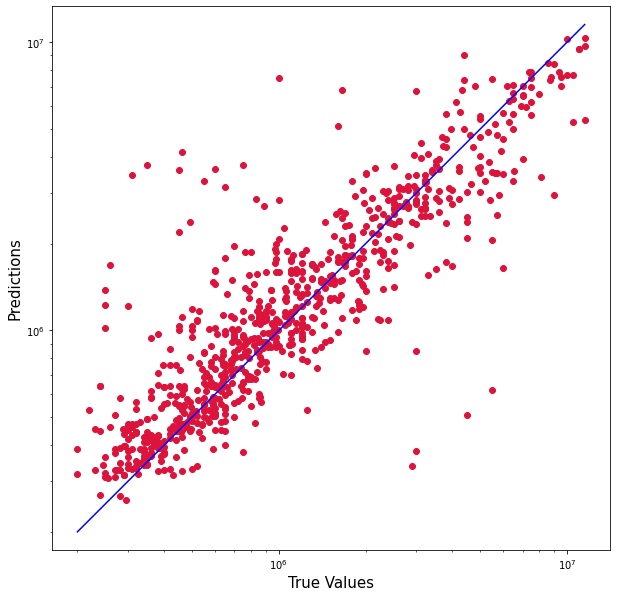

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_true, y_pred.round(), c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred.round()), max(y_true))
p2 = min(min(y_pred.round()), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()